In [1]:
import pandas as pd
import glob
import os

# Path to the directory containing the CSV files
data_dir = "../../resources/data/costs/default/"
csv_files = glob.glob(os.path.join(data_dir, "costs_*.csv"))
csv_files = sorted(csv_files)
csv_files


['../../resources/data/costs/default/costs_2020.csv',
 '../../resources/data/costs/default/costs_2025.csv',
 '../../resources/data/costs/default/costs_2030.csv',
 '../../resources/data/costs/default/costs_2035.csv',
 '../../resources/data/costs/default/costs_2040.csv',
 '../../resources/data/costs/default/costs_2045.csv',
 '../../resources/data/costs/default/costs_2050.csv',
 '../../resources/data/costs/default/costs_2055.csv',
 '../../resources/data/costs/default/costs_2060.csv']

In [2]:
heat_rate = 300 # gce/kwh
gce_to_kwh = 8.14/1000
eta= 1/(gce_to_kwh*heat_rate)
eta

0.4095004095004094

In [5]:
heat_rate = 280 # gce/kwh
gce_to_kwh = 8.14/1000
eta= 1/(gce_to_kwh*heat_rate)
eta

0.4387504387504387

In [6]:
import numpy as np
# from heat rate coal eq/kWh (Xiang et al nat energy 2023) in 2020 to 52% 2060 (D KEA)
l = np.linspace(eta,0.52, len(csv_files))
years = [int(f.split('_')[-1].split('.csv')[0]) for f in csv_files]
new_values = dict(zip(years, l))
new_values

{2020: 0.4387504387504387,
 2025: 0.4489066339066338,
 2030: 0.459062829062829,
 2035: 0.46921902421902417,
 2040: 0.4793752193752193,
 2045: 0.4895314145314145,
 2050: 0.49968760968760967,
 2055: 0.5098438048438049,
 2060: 0.52}

In [11]:

for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)

    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central coal CHP') & (df['parameter'] == 'efficiency')
    if mask.any():
        # Update the value to the new format: {year}:value
        old_value = df.loc[mask, 'value'].iloc[0]
        df.loc[mask, 'value'] = new_values[int(year)]*0.999
        df.loc[mask, "source"] = "Linear increase from Xiang et al nat energy 2023 to DKEA catalogue 2023 value for 2060"

        # # Overwrite the CSV file
        df.to_csv(file_path, index=False)

for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)

    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'coal') & (df['parameter'] == 'efficiency')
    if mask.any():
        # Update the value to the new format: {year}:value
        old_value = df.loc[mask, 'value'].iloc[0]
        df.loc[mask, 'value'] = new_values[int(year)]*1.001
        df.loc[mask, "source"] = "Linear increase from Xiang et al nat energy 2023 to DKEA catalogue 2023 value for 2060"

        # # Overwrite the CSV file
        df.to_csv(file_path, index=False)


In [9]:

for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)

    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central hydrogen CHP') & (df['parameter'] == 'efficiency')
    mask_gas = (df['technology'] == 'central gas CHP CC') & (df['parameter'] == 'efficiency')

    if mask.any():
        # Update the value to the new format: {year}:value
        old_value = df.loc[mask, 'value'].iloc[0]
        df.loc[mask, 'value'] = df.loc[mask_gas, 'value'].values*0.95
        df.loc[mask, "source"] = "gas CHP combined cycle efficiency *0.95 (based on a 60% H2 TEA https://www.mdpi.com/2071-1050/17/8/3369)"

        # # Overwrite the CSV file
        df.to_csv(file_path, index=False)

    # Read CSV
    df = pd.read_csv(file_path)

    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central hydrogen CHP') & (df['parameter'] == 'investment')
    mask_gas = (df['technology'] == 'central gas CHP CC') & (df['parameter'] == 'investment')

    if mask.any():
        # Update the value to the new format: {year}:value
        old_value = df.loc[mask, 'value'].iloc[0]
        df.loc[mask, 'value'] = df.loc[mask_gas, 'value'].values*1.1
        df.loc[mask, "source"] = "10% markup on gas CC as per H2-Ready Gas-fired Power Plants, Christidis et al 2023, Reiner Lemoine Institut"

        # # Overwrite the CSV file
        df.to_csv(file_path, index=False)


    # Read CSV
    df = pd.read_csv(file_path)

    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central hydrogen CHP') & (df['parameter'] == 'lifetime')
    mask_gas = (df['technology'] == 'central gas CHP CC') & (df['parameter'] == 'lifetime')

    if mask.any():
        # Update the value to the new format: {year}:value
        df.loc[mask, 'value'] = df.loc[mask_gas, 'value'].values-5
        df.loc[mask, "source"] = "5 year lifetime penalty vs gas - assumption"

        # # Overwrite the CSV file
        df.to_csv(file_path, index=False)



In [42]:
eta_coal_boiler = 0.78 # efficiency guess of coal historical boilers *not suitable for pathway mode*
for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = int(basename.split("_")[1].split(".")[0])
    
    # Read CSV
    df = pd.read_csv(file_path)
    df_ = pd.concat(
        [df, 
        pd.Series(["central coal boiler",year,"hist_efficiency",eta_coal_boiler,"p.u.", "expert guess for brownfield", "OPOP H4EKO class C"], index=df.columns).to_frame().T,
        pd.Series(["decentral coal boiler",year,"hist_efficiency",eta_coal_boiler,"p.u.", "expert guess for brownfield", "OPOP H4EKO class C"], index=df.columns).to_frame().T
        ])
    df_ = df_.drop_duplicates(subset=["technology", "parameter"], keep="first")
    df_.sort_values(by=["technology","year"], inplace=True)
    # # Overwrite the CSV file
    df_.to_csv(file_path, index=False)
    print("saved to ", file_path)


saved to  ../../resources/data/costs/default/costs_2020.csv
saved to  ../../resources/data/costs/default/costs_2025.csv
saved to  ../../resources/data/costs/default/costs_2030.csv
saved to  ../../resources/data/costs/default/costs_2035.csv
saved to  ../../resources/data/costs/default/costs_2040.csv
saved to  ../../resources/data/costs/default/costs_2045.csv
saved to  ../../resources/data/costs/default/costs_2050.csv
saved to  ../../resources/data/costs/default/costs_2055.csv
saved to  ../../resources/data/costs/default/costs_2060.csv


In [27]:
df_.loc[df_.duplicated(subset=["technology", "parameter"], keep=False)]

,technology,year,parameter,value,unit,source,further description


<Axes: xlabel='year', ylabel='value'>

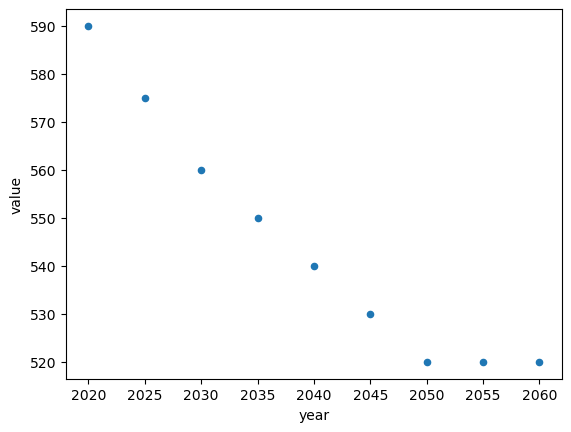

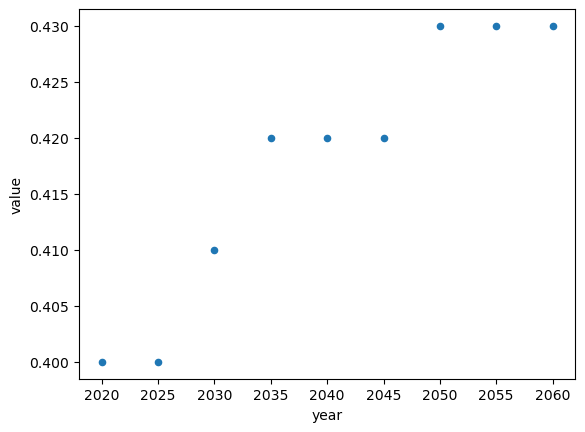

In [8]:
data = {}
for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)
    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central gas CHP')
    if mask.any():
        # Update the value to the new format: {year}:value
        data[year] = df.loc[mask]
pd.concat(data.values()).query("parameter=='investment'").plot(kind="scatter", x="year", y="value")
pd.concat(data.values()).query("parameter=='efficiency'").plot(kind="scatter", x="year", y="value")

# FIX CC CHP

In [9]:
# piecewise linear interpolation of DKEA values
dk_ea_invest = {
 2020: 0.88*1000,
 2030: 0.83*1000,
 2050: 0.8*1000}


In [10]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
x = np.array(list(dk_ea_invest.keys()))
y = np.array(list(dk_ea_invest.values()))

# Exponential decay function
def exp_decrease(x, a, b, c):
    return a * np.exp(b * (x - x[0])) + c

# Fit
popt, _ = curve_fit(exp_decrease, x, y, p0=(y[0], -0.1, 750))

# popt contains the fitted parameters a and b
a, b, c = popt
print(f"Fitted parameters: a={a}, b={b}")

# Example: predict for all years
years_fit = np.arange(2020, 2061, 5)
y_fit = exp_decrease(years_fit, a, b, c)

plt.scatter(dk_ea.keys(), dk_ea.values(), marker="D", color = "black")
plt.scatter(years_fit, y_fit, color='red', alpha=0.9)
fit = dict(zip(years_fit, y_fit))

Fitted parameters: a=86.49837306176029, b=-0.08628579192817794


/p/tmp/ivanra/anaconda/ipykernel_788578/364525496.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_decrease, x, y, p0=(y[0], -0.1, 750))


NameError: name 'dk_ea' is not defined

In [ ]:
data = {}
for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)
    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central gas CHP CC') & (df['parameter'] == 'investment')
    if mask.any():
        # Update the value to the new format: {year}:value
        # Find the row for 'coal' and column for 'efficiency'
        if mask.any():
            # Update the value to the new format: {year}:value
            old_value = df.loc[mask, 'value'].iloc[0]
            df.loc[mask, 'value'] = f"{fit[int(year)]:.2f}"
            df.loc[mask,"further description"] = "05 Gas turb. CC, steam extract.: Investment"

            # # Overwrite the CSV file
            df.to_csv(file_path, index=False)

/p/tmp/ivanra/anaconda/ipykernel_3724012/3321488110.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '849.69' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'value'] = f"{fit[int(year)]:.2f}"
/p/tmp/ivanra/anaconda/ipykernel_3724012/3321488110.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '800.00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'value'] = f"{fit[int(year)]:.2f}"
/p/tmp/ivanra/anaconda/ipykernel_3724012/3321488110.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '880.00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'value'] = f"{fit[int(year)]:.

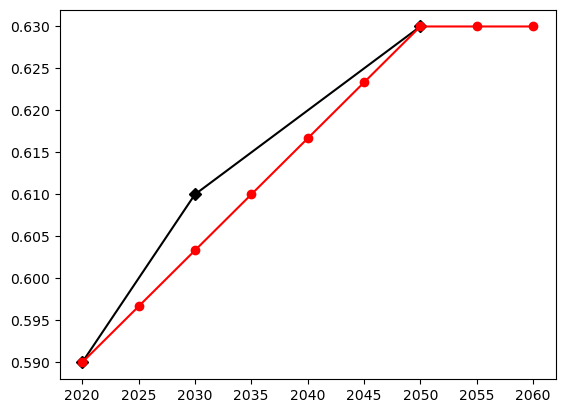

In [ ]:
# piecewise linear interpolation of DKEA values
dk_ea = {
 2020: 0.59,
 2030: 0.61,
 2050: 0.63}
years = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060   ]
plt.plot(dk_ea.keys(), dk_ea.values(), marker="D", color = "black")
eff_interp = np.linspace(0.59,0.63,len(years)-2).tolist() + [0.63,0.63]
plt.plot(years, eff_interp, marker="o", color = "red")
eff_d = dict(zip(years, eff_interp))

In [ ]:
data = {}
for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)
    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central gas CHP CC') & (df['parameter'] == 'efficiency')
    if mask.any():
        # Update the value to the new format: {year}:value
        # Find the row for 'coal' and column for 'efficiency'
        if mask.any():
            # Update the value to the new format: {year}:value
            old_value = df.loc[mask, 'value'].iloc[0]
            df.loc[mask, 'value'] = eff_d[int(year)]
            df.loc[mask,"further description"] = "05 Gas turb. CC, steam extract.:  Efficiency"

            # # Overwrite the CSV file
            df.to_csv(file_path, index=False)